<a href="https://colab.research.google.com/github/mabittar/Portfolio/blob/master/Reconhecendo_Sinais_Tr%C3%A2nsito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento de Sinais de Trânsito

Você ja deve ter ouvido sobre veículos autônomos, que são capazes de conduzir o veículo sozinho até o destino desejado. Mas para alcançar o nível 5 em autonomia, é necessário que o veículo entenda e obdeça todas as leis de trânsito.

No campo da Inteligência artificial e em tecnologia, muitos pesquisadores e grandes companhias como Tesla, Uber, Google, Mercedes, toyota estão desenvolvendo seus próprios carros autônomos. Para obter a acurácia necessária nessa tecnologia, os veículos precisam reconhecer e interpretar as placas de sinalização e para que tomarem as decisões esperadas.

<center><img alt="auto drive" src="https://uploads.volkswagen-newsroom.com/system/production/media/18995/images/7c11c1f9c948e33a0dfd6614ab81e4152fe3bee6/DB2014AU01094_x750.jpg?1580944803"></center>


## Sinais de Trânsito

Mas o que são sinais de trânsito?

As placas ou sinais de trânsito estão localizadas ao lado ou suspensas sobre a via, transmitindo mensagens, através de legendas e maioritariamente símbolos conhecidos anteriormente e legalmente instituídos. Estas placas têm como objetivo manter o fluxo de trânsito em ordem e em segurança.

Existem diferentes sinais de trânsito, por exemplo que delimitam a velocidade, conversão proibida, obrigatório a conversão a direita, proibido veículos pesadas. O processo de identificação de sinais de trânsito envolve classificar a qual grupo ele pertence (placas de regulamentação, placas de advertência.

Para esse projeto utilizarei um dataset público disponível no [Kraggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). 

Infelizmente não encontrei as placas categorizadas para sinais de trânsito brasileiro.


In [ ]:
# !pip install kaggle; #caso seja necessário atualizar a biblioteca no google colab

from google.colab import files
files.upload() #enviar o arquivo kaggle.json

# antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip

In [18]:
from google.colab import drive
!ls /content/

kaggle.json  Meta      sample_data  Test      train  Train.csv
meta	     Meta.csv  test	    Test.csv  Train


### Simple Dataset Loader

O objeto (class) a seguir carrega o dataset a partir do drive e carrega os dados e rótulos (labels), que são tuplas de matriz numpy com dados e labels.

In [19]:
# import the necessary packages
import numpy as np
import cv2
import os

# classe Simple Dataset Loader
# objeto para leitura dos dados
class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# instacia o preprocessador
		self.preprocessors = preprocessors

		# se o preprocessardor for None, inicializa como uma lista vazia
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# inicializa a lista de características (features) e rótulos (labels)
		data = []
		labels = []
		classes = 43

		# loop sobre as imagens
		for (i, imagePath) in enumerate(imagePaths):
			# carrega as imagens e extrai o classe de rótulos assumindo que
			# o caminho siga o formato /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# checa se o preprocessaor não é nulo
			if self.preprocessors is not None:
				# loop no preprocessaor e aplicar para cada imagem 
				for p in self.preprocessors:
					image = p.preprocess(image)

			# trata a imagem processada como "feature vector"
			# atualiza a lista de rótulos
			data.append(image)
			labels.append(label)

			# display do 'verbose' 
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] imagem processada {}/{}".format(i + 1,
					len(imagePaths)))

		# retorna a tupla de dados e rótulos
		return (np.array(data), np.array(labels))

### SimpleProcessor

O objeto (class) SimpleProcessor recebe as imagens do banco de dados e redefine o tamanho de cada imagem no dataset

In [20]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

Com os objetos podemos agora importar os dados para o nosso dataset de trabalho

 - data = imagens

 - labels = rótulos

In [22]:
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader
from imutils import paths

#caminho para a pasta
imagePath = list(paths.list_images("/content/train/"))
#definindo o preprocessador para reduzir as imagens em 3.072 (32x32x3) pixels
sp = SimplePreprocessor(32, 32)
#instanciando o SDL
sdl = SimpleDatasetLoader(preprocessors=[sp])

#carregando as imagens e rótulos
(data, labels) = sdl.load(imagePath)


Com as imagens importadas, vamos verificar nossas entradas: 
 - quantidade
 - largura x altura em pixels
 - colorida (3) ou b&w (1)
 - verificar se a quantidade de rótulos coincide com a quantidade de imagens

In [23]:
print("Tamanho do dataset {} (Quantidade, largura (px), altura(px), 3=rgb)" .format(data.shape))
print("Rótulos {}" .format(labels.shape))

Tamanho do dataset (39209, 32, 32, 3) (Quantidade, largura (px), altura(px), 3=rgb)
Rótulos (39209,)


A partir da API `Scikit Learn` iremos importar o train-test-split.

Da biblioteca `Keras` iremos importar o encoder para os labels.

In [24]:
#1. importando as bibliotecas necessárias
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#2. dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


#3. Enconder do vetor alvo
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43) 

## Rede Neural Convolucional

Quando tratamos de identificação e processamento de imagens, um dos métodos que vêm sendo aplicado com maior sucesso é um método de `Deep Learning` conhecido como **Convolutional Neural Network - CNN** ou (ConvNet).

Neste [artigo]("https://data-flair.training/blogs/convolutional-neural-networks-tutorial/") é possível entender como uma rede neural interpreta uma imagem.

<center><img alt="ConvNet" src="https://d2h0cx97tjks2p.cloudfront.net/blogs/wp-content/uploads/sites/2/2019/07/introduction-to-CNN.png"></center>

Resumidamente uma rede neural decompõe uma imagem em diversos pixels e utiliza uma variação de perceptrons multicamadas para *aprender* como uma imagem é formada.



Da biblioteca `Keras` utilizaremos o modelo sequencial, pois conforme [documentação oficial](https://keras.io/guides/sequential_model/) é apropriado para uma pilha simples de camadas onde cada camada tem exatamente um tensor de entrada e um tensor de saída (para o nosso caso: reconhecer imagens).

As camadas:

 - Conv2D ou 2D convolutional layer produz um tensor de saída (output), os hyper parâmetros `filters` define a dimensão de saída do tensor e o `kernel_size` especifica a altura e largurada janela convolutional 2D.

- MaxPool2D: operação máxima de pooling para dados espaciais 2D. Reduz a resolução da representação de entrada tomando o valor máximo sobre a janela definida por pool_size para cada dimensão ao longo do eixo dos recursos.

- Dropout: Aplica Dropout à entrada. A camada Dropout define aleatoriamente as unidades de entrada para 0 com uma frequência de taxa em cada etapa durante o tempo de treinamento, o que ajuda a evitar overfitting.

- Flatten: Nivela a entrada. Não afeta o tamanho do batch.

- Dense: Ela tem como objetivo calcular uma função de ativação em conjunto com os dados de entrada e pesos


A imagem a seguir exemplifica os parâmetros anteiores

<center><img alt = "CNN", src="https://www.codeproject.com/KB/AI/1273179/006443fd-821a-4e31-b017-7081e1028f75-r-700.Png"></center>




In [25]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#1. Instaciando o modelo e definindo hyper parâmetros
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu' ))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#2. Compilando o modelo
model.compile(
    loss='categorical_crossentropy', 
    optimizer='Adam', metrics=['accuracy']
    )

#3. definindo passos
epochs = 20

#4. Fit do modelo
resultado = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/20
491/491 [==============================] - 4s 8ms/step - loss: 1.8831 - accuracy: 0.5541 - val_loss: 0.2059 - val_accuracy: 0.9551
Epoch 2/20
491/491 [==============================] - 3s 7ms/step - loss: 0.3487 - accuracy: 0.9039 - val_loss: 0.0839 - val_accuracy: 0.9800
Epoch 3/20
491/491 [==============================] - 3s 7ms/step - loss: 0.1946 - accuracy: 0.9464 - val_loss: 0.0458 - val_accuracy: 0.9884
Epoch 4/20
491/491 [==============================] - 3s 7ms/step - loss: 0.1607 - accuracy: 0.9566 - val_loss: 0.0376 - val_accuracy: 0.9909
Epoch 5/20
491/491 [==============================] - 3s 7ms/step - loss: 0.1365 - accuracy: 0.9618 - val_loss: 0.0446 - val_accuracy: 0.9906
Epoch 6/20
491/491 [==============================] - 3s 7ms/step - loss: 0.1262 - accuracy: 0.9658 - val_loss: 0.0468 - val_accuracy: 0.9897
Epoch 7/20
491/491 [==============================] - 3s 7ms/step - loss: 0.1048 - accuracy: 0.9715 - val_loss: 0.0288 - val_accuracy: 0.9932
Epoch 

Após 20 passos (epochs) o resultado da acurácia encontra-se estável.

Vamos plotar os gráficos para avaliarmos os resultados

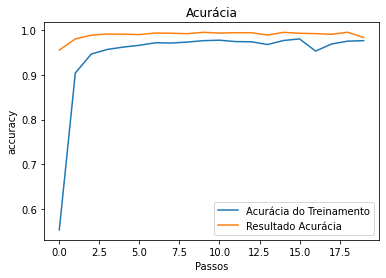

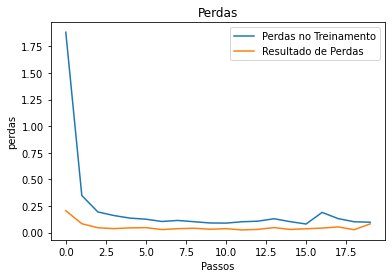

In [26]:
import matplotlib.pyplot as plt
import pandas as pd


plt.figure(0)
plt.plot(resultado.history['accuracy'], label='Acurácia do Treinamento')
plt.plot(resultado.history['val_accuracy'], label='Resultado Acurácia')
plt.title('Acurácia')
plt.xlabel('Passos')
plt.ylabel('accuracy')
plt.legend()


plt.figure(1)
plt.plot(resultado.history['loss'], label='Perdas no Treinamento')
plt.plot(resultado.history['val_loss'], label='Resultado de Perdas')
plt.title('Perdas')
plt.xlabel('Passos')
plt.ylabel('perdas')
plt.legend()

## Teste do Modelo

Nosso conjunto de dados contém uma pasta própria para execução dos teste. 

Já possuímos os detalhes relacionados ao caminho da imagem e seus respectivos rótulos de classe. Iremos recuperar o caminho e os rótulos da imagem usando pandas. 

Então, para prever o modelo, temos que redimensionar nossas imagens para 30 × 30 pixels e fazer um array numpy contendo todos os dados da imagem. 

Do `sklearn.metrics`, utilizaremos o *precision_score* e observamos como nosso modelo previu os rótulos reais.

In [27]:
from sklearn.metrics import accuracy_score, classification_report
y_test = pd.read_csv('Test.csv')

y_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Da visualização podemos observar que:
 - labels = ClassId
 - imagens = Path

Vamos importá-los para um novo dataset e utilizá-lo para comparar a previsão e obter o resultado final

In [28]:
from PIL import Image
labels = y_test["ClassId"].values #obter o valor de classificação
imgs = y_test["Path"].values #obter as imagens correspondentes a classificação

data = []

# iremos fazer um loop a tupla imgs para carregar a respectiva imagem
for img in imgs:
  image = Image.open(img)
  image = image.resize((32,32))
  data.append(np.array(image))

#carregando nossa variável de teste
X_test = np.array(data)

#fazendo previsão do modelo
y_pred = np.argmax(model.predict(X_test), axis=-1) #notação atualizada

#verificando os resultados
acc = accuracy_score(labels, y_pred)
print("A acurácia do modelo é {:.3%}.".format(acc))

A acurácia do modelo é 84.014%.


**Observação**

De acordo com a [documentação atualizada]("https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict") como estamos tentando realizar a previsão de uma categoria devemos utilizar `np.argmax(model.predict(X_test), axis=-1)` para evitar avisos.

 Nosso modelo acertou mais de 80% das sinalização corretamente.

### Sinalização Aletória

E se fizermos o teste com uma placa de trânsito aleatória do Brasil, nosso modelo funcionaria?

Pensando nisso procurei uma placa aleatória no [google image]("https://www.google.com/search?q=placas+de+transito+limite+de+velocidade&rlz=1C1GCEU_pt-BRBR821BR821&sxsrf=ALeKk02UNUVbCJnettWJK3EPZMtxn5mElA:1600641755081&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiDl-WZ5_jrAhVTHLkGHSs7BZIQ_AUoAXoECAwQAw&biw=1366&bih=625"). 

Carreguei a imagem para o Colab, podemos visualizá-la a seguir: 

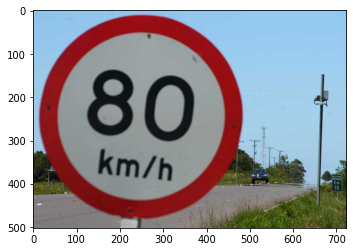

In [29]:
import requests
url = 'https://4.bp.blogspot.com/-l8AxhIdF15E/UK6eLm3ww0I/AAAAAAAAAoE/g-y3LuHEuB8/s1600/80+pardal-intelog+net.jpg' 
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('RdYlBu'));

O próximo passo é tratar a imagem e colocar no padrão para o que o nosso modelo possa fazer a previsão:


1.   importaremos a imagem para uma matriz numpy
2.   requadro da imagem
3.   iremos plotá-la para verificação
4.   faremos o *resize* para torná-la compatível com o modelo matriz (objeto, px, px, RGB)

(32, 32, 3)


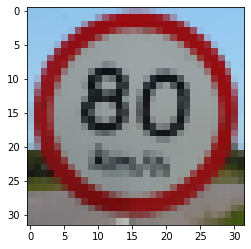

In [30]:
img = np.asarray(img)
img = img[:, :500]
img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
plt.imshow(img, cmap = plt.get_cmap('RdYlBu'))
print(img.shape)
img = img.reshape(1, 32, 32, 3)

In [31]:
#nesse arquivo consegui obter a nome para cada categoria de pasta
categoria = pd.read_csv('https://bitbucket.org/jadslim/german-traffic-signs/raw/a11dc223e3905f459e33abdb86673730e1e78509/signnames.csv', index_col='ClassId')


No passo anterior importamos de um arquivo os rótulos (labels) para cada pasta.

Com a imagem pronta, iremos realizar o teste com o nosso modelo CNN criado anteriormente.

In [32]:
previsao = np.argmax(model.predict(img), axis=-1)
print(categoria.loc[previsao])

                     SignName
ClassId                      
5        Speed limit (80km/h)


#Conclusão

Neste notebook foi possivél demonstrar superficialmente um modelo de Deep Learning para reconhecimento de imagens.

Entretanto o notebook é um exemplo estático (podendo variar a imagem de testes fnial), ele seria o ponto de partida para uma aplicação de análises de placas de trânsito em tempo real. Os próximos passos seriam criar uma interface web e implementar a identificação em tempo real através de um app para celular. Seria possível tb registrar as coordenadas (lat, lon) para cada placa apontada.